In [1]:
## Every notebook should start with this header
# The next lines mean that changes in Python files are instantaneously applied
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from pathlib import Path

# As a sanity check, print out the current working directory
print(f"Running in {Path('').absolute()}")

import cfspopcon
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr
from cfspopcon.unit_handling import magnitude_in_units, ureg

import extended_lengyel
plt.style.use('paper_plots.mplstyle')

Running in /Users/tbody/Projects/extended-lengyel/notebooks


In [2]:
def extended_lengyel_model_with_S_fconv_Zeff_correction_for_fixed_qperp_tar(
    **overrides
):
    algorithm = cfspopcon.CompositeAlgorithm.from_list([
        "calc_target_electron_temp_from_cc_fit",
        "initialize_kallenbach_model",
        "calc_electron_temp_from_cc_fit",
        "calc_electron_density_from_cc_fit",
        "calc_power_loss_from_cc_fit",
        "calc_parallel_heat_flux_from_conv_loss",
        "ignore_s_parallel_width_for_cc_interface",
        "run_spatial_lengyel_model",
        "postprocess_spatial_lengyel_model",
        "set_radas_dir",
        "set_single_impurity_species",
        "extended_lengyel_model_with_S_fconv_Zeff_correction",
        "calc_lambda_q_from_lambda_int",
        "calc_upstream_field",
        "calc_fieldline_pitch_at_omp",
        "calc_flux_tube_cross_section_area_out_of_divertor",
        "calc_power_crossing_separatrix_from_heat_flux_in_flux_tube",
        "calc_radiative_efficiency",
        "calc_sound_speed_at_target",
        "calc_flux_density_to_pascals_factor",
        "calc_target_density",
        "calc_parallel_to_perp_factor",
        "calc_ion_flux_to_target",
        "calc_divertor_neutral_pressure",
        "calc_qdet_ext_7a",
        "calc_qdet_ext_7b",
    ])

    ds = xr.Dataset(data_vars=extended_lengyel.read_config(
        elements        = ["base", "machine_geometry", "field_at_omp"],
        keys            = algorithm.input_keys,
        allowed_missing = algorithm.default_keys,
        overrides       = overrides,
    ))

    algorithm.validate_inputs(ds)

    return algorithm.update_dataset(ds)

In [3]:
def extended_lengyel_model_with_S_fconv_Zeff_alpha_t_correction(
    **overrides
):
    algorithm = cfspopcon.CompositeAlgorithm.from_list([
        "calc_target_electron_temp_from_cc_fit",
        "calc_upstream_field",
        "calc_cylindrical_edge_safety_factor",
        "calc_fieldline_pitch_at_omp",
        "set_radas_dir",
        "set_single_impurity_species",
        "extended_lengyel_model_with_S_Zeff_and_alphat_correction",
        "calc_radiative_efficiency",
        "calc_lambda_int_from_lambda_q",
        "calc_sound_speed_at_target",
        "calc_flux_density_to_pascals_factor",
        "calc_target_density",
        "calc_parallel_to_perp_factor",
        "calc_heat_flux_perp_to_target",
        "calc_ion_flux_to_target",
        "calc_divertor_neutral_pressure",
        "calc_qdet_ext_7a",
        "calc_qdet_ext_7b",
    ])

    ds = xr.Dataset(data_vars=extended_lengyel.read_config(
        elements        = ["base", "machine_geometry", "field_at_omp"],
        keys            = algorithm.input_keys,
        allowed_missing = algorithm.default_keys,
        overrides       = overrides,
    ))

    algorithm.validate_inputs(ds)

    return algorithm.update_dataset(ds)

In [4]:
from scipy.optimize import curve_fit

def gradient(x, m):
    """Simple gradient fit."""
    return m * x

def fit_radiative_efficiency(impurity_fraction, cz_fz, max_cz_fz=2.0):
    """Fit the radiative efficiency (fz) value to the given data."""

    mask = cz_fz < max_cz_fz

    x, y = xr.broadcast(impurity_fraction.where(mask), cz_fz.where(mask))

    x, y = magnitude_in_units(x, "").values.flatten(), magnitude_in_units(y, "").values.flatten()


    mask_nan = ~(np.isnan(x) | np.isnan(y))

    popt, pcov = curve_fit(
        gradient,
        xdata = x[mask_nan],
        ydata = y[mask_nan],
    )

    p_sigma = np.sqrt(np.diag(pcov))

    return popt[0], p_sigma[0]

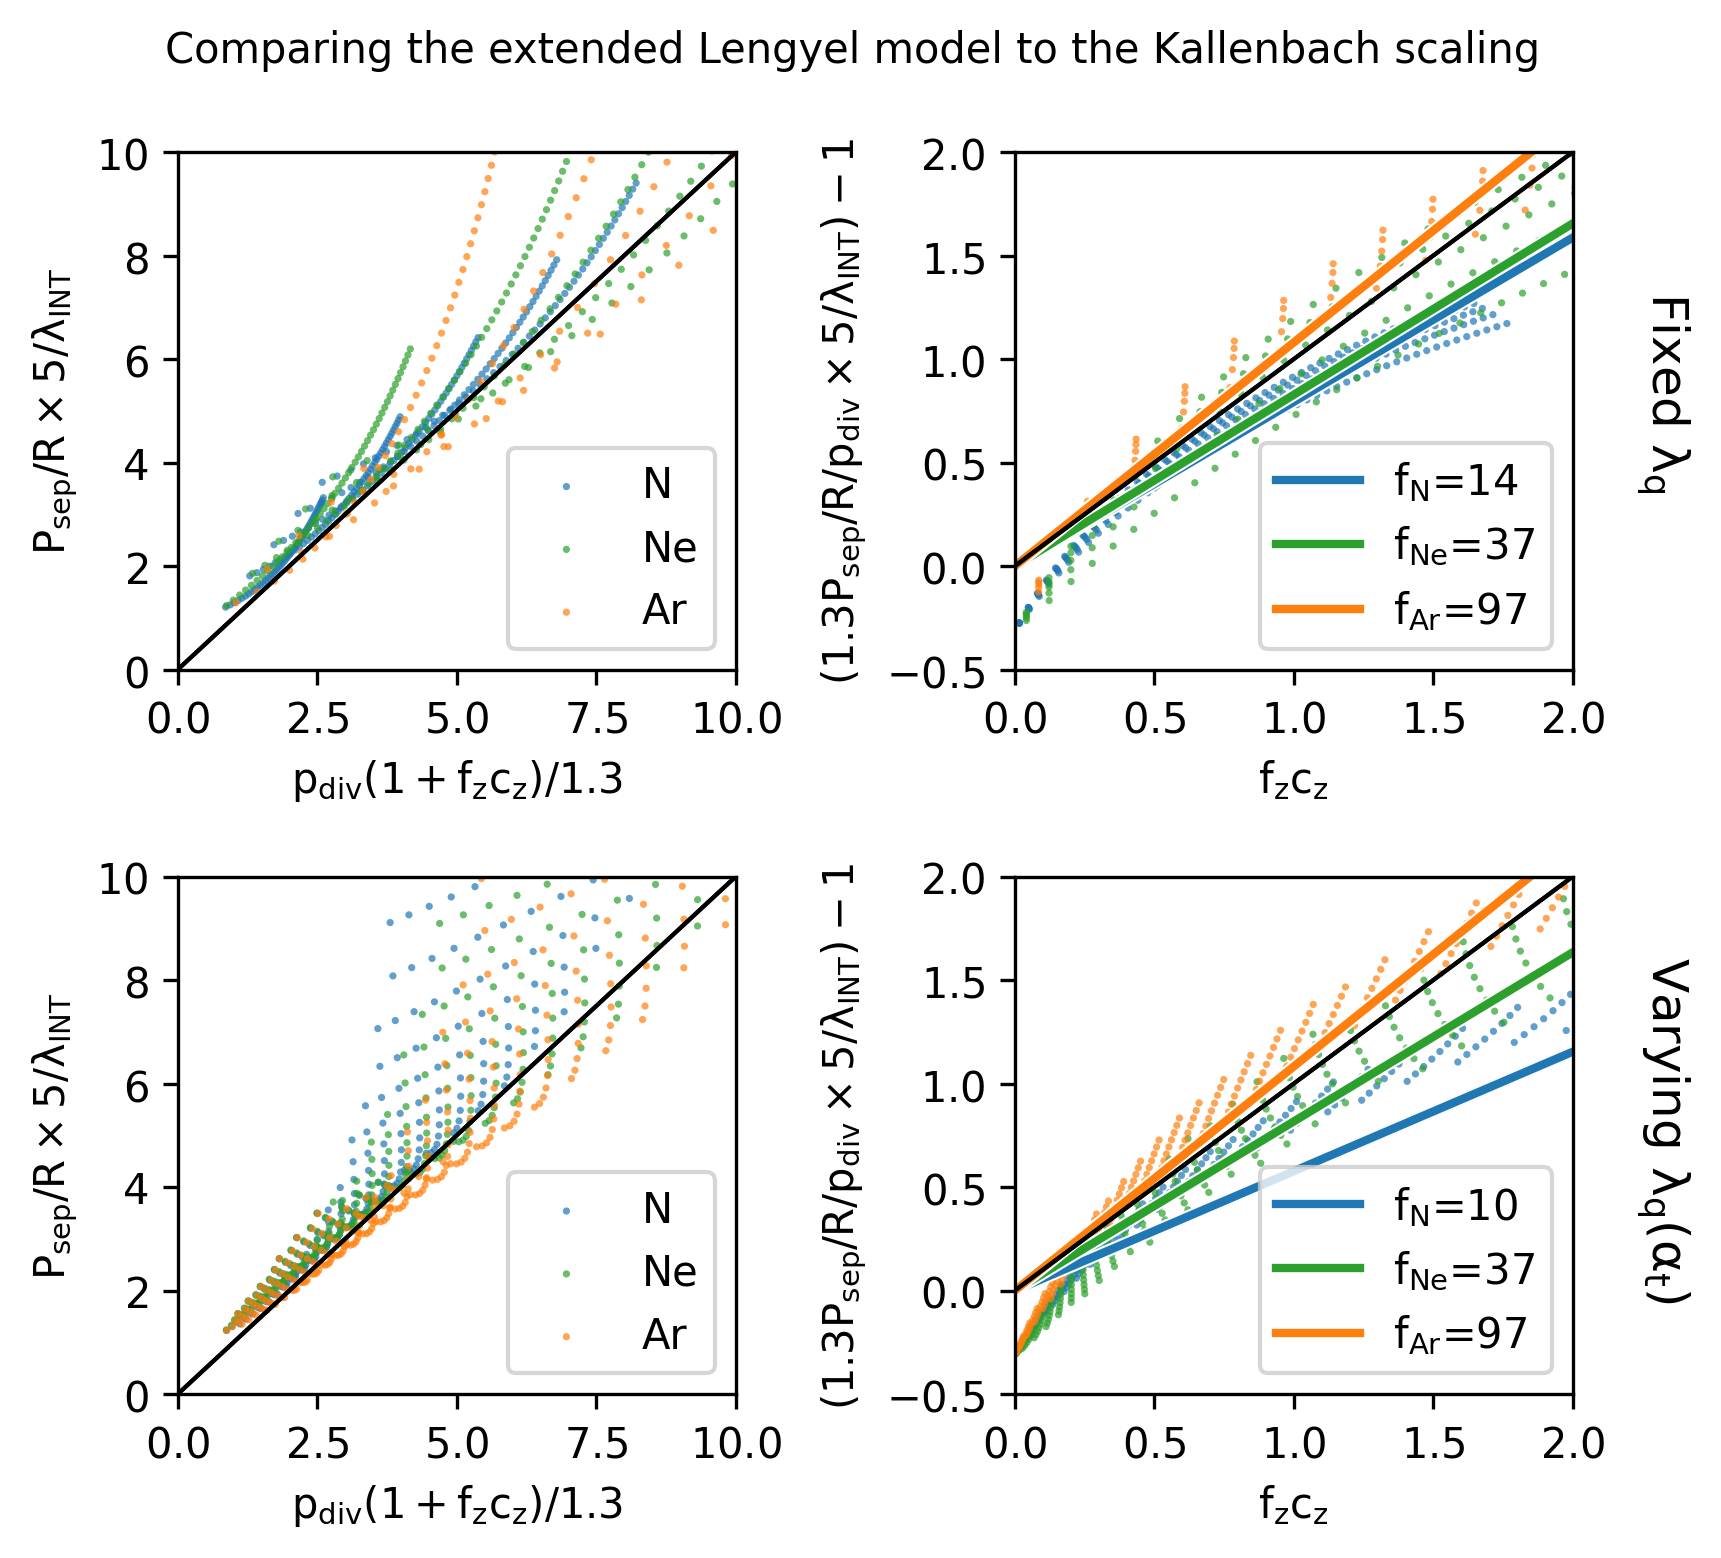

In [5]:
import matplotlib.patheffects as path_effects

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))
s = 3.0
fit_line_linewidth = 2.0
scatter_alpha = 0.7

for (label, color), impurity_species in {
  ("N", "C0") : cfspopcon.named_options.AtomicSpecies.Nitrogen,
  ("Ne", "C2"): cfspopcon.named_options.AtomicSpecies.Neon,
  ("Ar", "C1"): cfspopcon.named_options.AtomicSpecies.Argon,
}.items():
    for i in range(2):

        if i == 0:
            ds = extended_lengyel_model_with_S_fconv_Zeff_correction_for_fixed_qperp_tar(
                heat_flux_perp_to_target = extended_lengyel.promote_to_coordinate(np.linspace(0.8, 2.4, num=5), ureg.MW/ureg.m**2, dims="heat_flux_perp_to_target"),
                impurity_fraction        = extended_lengyel.promote_to_coordinate(np.linspace(0.1, 10.0, num=50), ureg.percent, dims="impurity_fraction"),
                impurity_species    = impurity_species)
        else:
            ds = extended_lengyel_model_with_S_fconv_Zeff_alpha_t_correction(
                power_crossing_separatrix   = extended_lengyel.promote_to_coordinate(np.logspace(-2, 2, num=100), ureg.MW, dims="power_crossing_separatrix"),
                separatrix_electron_density = extended_lengyel.promote_to_coordinate(np.logspace(-2, 2, num=100), ureg.n20, dims="separatrix_electron_density"),
                impurity_species       = impurity_species)

        heat_flux_perp_to_target = magnitude_in_units(ds["heat_flux_perp_to_target"], ureg.MW / ureg.m**2)
        mask                     = (heat_flux_perp_to_target >= 0.8) & (heat_flux_perp_to_target <= 2.4)

        x, y = xr.broadcast(
            ds["Psep/R/lambda_int"].where(mask),
            ds["p0(1+fz*cz)/1.3"].where(mask),
        )

        axs[i][0].scatter(magnitude_in_units(x, ""), magnitude_in_units(y, ""), c=color, s=s, label=label, alpha=scatter_alpha, edgecolors="none")

        x, y = xr.broadcast(
            ds["cz*fz"].where(mask),
            ds["1.3Psep/R/p0/lambda_int - 1"].where(mask),
        )

        axs[i][1].scatter(magnitude_in_units(x, ""), magnitude_in_units(y, ""), c=color, s=s, alpha=scatter_alpha, edgecolors="none")

        fz, sigma_fz = fit_radiative_efficiency(ds["impurity_fraction"].where(mask), ds["1.3Psep/R/p0/lambda_int - 1"].where(mask))

        axs[i][1].axline((0, 0), (1, fz / magnitude_in_units(ds["radiative_efficiency"], "")),
                         color=color, linewidth=fit_line_linewidth, label=f"$f_{{{label}}}$={fz:.0f}",
                         path_effects = [path_effects.Stroke(linewidth=fit_line_linewidth * 1.5, foreground='white'), path_effects.Normal()]
        )

for ax in axs[:, 0]:
  ax.legend()
  ax.axline((0, 0), (1, 1), color="k", linewidth=1.0)
  ax.set_xlim(0, 10)
  ax.set_ylim(0, 10)
  ax.set_xlabel("$p_{div}(1+f_z c_z)/1.3$")
  ax.set_ylabel("$P_{sep}/R \\times 5 / \\lambda_{INT}$")

for ax in axs[:, 1]:
  ax.legend()
  ax.axline((0, 0), (1, 1), color="k", linewidth=1.0)
  ax.set_xlim(0, 2)
  ax.set_ylim(-0.5, 2)
  ax.set_xlabel("$f_z c_z$")
  ax.set_ylabel("$(1.3P_{sep}/R / p_{div} \\times 5 / \\lambda_{INT}) - 1$")

fig.subplots_adjust(wspace=0.5, hspace=0.4, top=0.8)

for ax in axs.flatten():
    ax.axline((0, 0), (1, 1), color="k", linewidth=1.0)

fig.text(0.5, 0.85, "Comparing the extended Lengyel model to the Kallenbach scaling", ha="center", fontsize=10)
fig.text(0.95, 0.62, "Fixed $\\lambda_q$", ha="center", fontsize=12, rotation=270)
fig.text(0.95, 0.17, "Varying $\\lambda_q(\\alpha_t)$", ha="center", fontsize=12, rotation=270)

fig.savefig(extended_lengyel.directories.output_dir / "combined_comparison_to_Kallenbach_scaling.png", dpi=300, bbox_inches="tight")